In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from common.working_dataset_config import working_datetime, test_date_time_strings
from data_management.data_crawler import DataManager
from data_management.data_reshaper import reshape_data, prepare_dataset, flatten_data
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [2]:
date_strings = ['01.01.2021 00:00', '31.12.2023 23:59']
test_dates_string = ['01.01.2024 00:00', '30.04.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=False)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 40)
single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 40)
multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 40)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-05-10 16:16:39+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/
    # Minimal data: 2023-10-28 07:17:18+00:00
    # Maximal data: 2024-05-10 16:15:37+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2022-02-12 21:11:18+00:00
    # Maximal data: 2024-05-10 16:15:59+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-05-10 16:19:11+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 2024-05-10 16:20:04+00:00
Loading station data: Konopnickiej  https://datahub.ki.agh.edu.pl/api/endpoints/75/data/
    # Minimal data

In [3]:
class RandomClassifier():
    def __init__(self):
        self.xdxd = DecisionTreeClassifier(random_state=0)

    def fit_data(self, labeled_data, column):
        X, y = prepare_dataset(labeled_data, column)
        self.xdxd.fit(X, y)

    def test_accuracy(self, labeled_data, column):
        X_set, y_set = prepare_dataset(labeled_data, column)
        predicted = self.xdxd.predict(X_set)
        accuracy = accuracy_score(y_set, predicted)
        print("Accuracy of DecisionTree: ", accuracy)
        wrong_predicitons = [[DataLabel(p), DataLabel(y)] for p, y in zip(predicted, y_set) if p != y]
        print("[Predicted, Actual]")
        for error in wrong_predicitons:
            print(str(error[0]) + ", " + str(error[1]))
        return accuracy


In [4]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None, criterion = None):
        self.xdxd = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion,random_state=0)

    def fit_data(self, labeled_data, column):
        X, y = prepare_dataset(labeled_data, column)
        X = flatten_data(X)
        self.xdxd.fit(X, y)

    def test_accuracy(self, labeled_data, column):
        X_set, y_set = prepare_dataset(labeled_data, column)
        X_set = flatten_data(X_set)
        predicted = self.xdxd.predict(X_set)
        accuracy = accuracy_score(y_set, predicted)
        precision = precision_score(y_set, predicted, average='weighted')
        recall = recall_score(y_set, predicted,  average='weighted')
        f1 = f1_score(y_set, predicted, average='weighted', zero_division=np.nan)
        # print("Accuracy of Decision Tree: ", accuracy)
        # wrong_predicitons = [[DataLabel(p), DataLabel(y)] for p, y in zip(predicted, y_set) if p != y]
        # print("[Predicted, Actual]")
        # for error in wrong_predicitons:
        #     print(str(error[0]) + ", " + str(error[1]))
        return accuracy, precision, recall, f1

In [5]:
from matplotlib import pyplot as plt


metrics = ['gini', 'entropy']
max_depth_of_tree = 100
config_list = [
    {
        'name': 'dt_SDSC',
        'columns': [PM10],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'dt_SDMC',
        'columns': [PM10, PM1, PM2_5],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'dt_MDSC',
        'columns': [PM10],
        'training_datas': multi_data,
        'test_datas': test_data
    },
    {
        'name': 'dt_MDMC',
        'columns': [PM10, PM1, PM2_5],
        'training_datas': multi_data,
        'test_datas': test_data
    }
]
final_result = []
for criterion in metrics:
    results = []
    for config in config_list:
        name = config['name']
        print("checking: " + name + " " + criterion)
        max_depth = []
        acc = []
        prec = []
        rec = []
        f1_s = []
        depth = []
        for i in range(1, max_depth_of_tree):
            if i % 30 == 0:
                print(f'   {i}')
            knn = MyDecisionTreeClassifier(i, criterion)
            knn.fit_data(config['training_datas'], config['columns'])
            accuracy, precision, recall, f1 = knn.test_accuracy(config['test_datas'], config['columns'])
            max_depth.append(i)
            acc.append(accuracy)
            prec.append(precision)
            rec.append(recall)
            f1_s.append(f1)            
            depth.append(knn.xdxd.get_depth())
            
        results.append({
            'criterion': criterion, 
            'name': name, 
            'max_depth': max_depth,
            'acc':acc, 
            'prec':prec,
            'recall':rec,
            'f1':f1_s,
            'depth' : depth
        })
    
    final_result.append({'criterion': criterion, 'results':results})

checking: dt_SDSC gini


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_SDMC gini


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_MDSC gini


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_MDMC gini


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_SDSC entropy


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_SDMC entropy


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_MDSC entropy


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90
checking: dt_MDMC entropy


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

   30
   60
   90


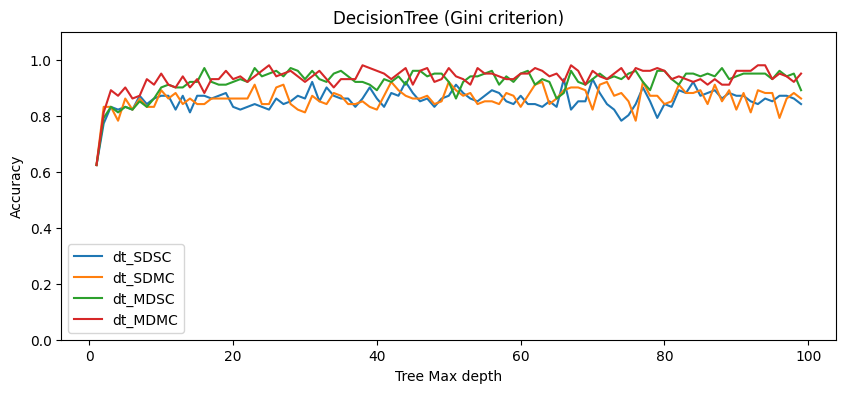

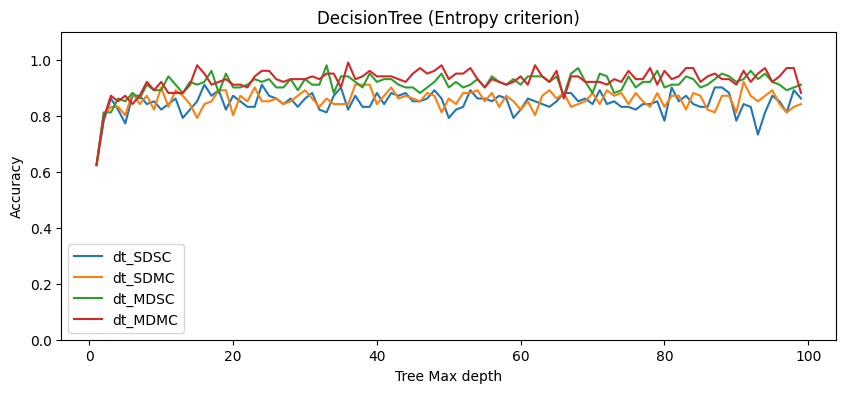

######################################


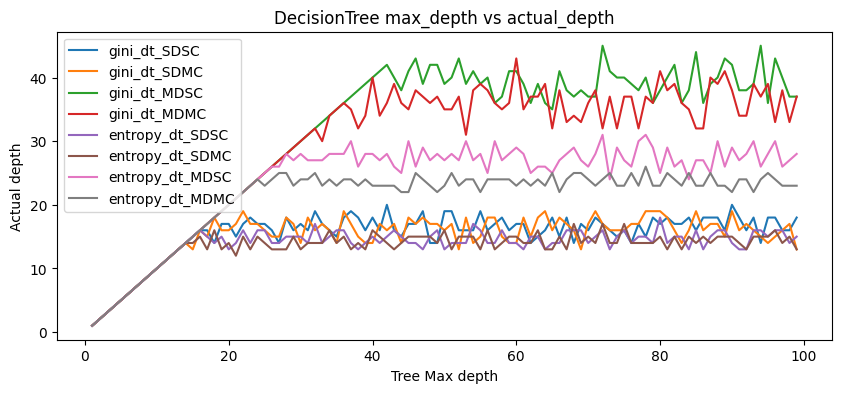

In [6]:
criterion = 'criterion'

for r in final_result:
    plt.figure(figsize=(10, 4))
    plt.title(f'DecisionTree ({r[criterion].title()} criterion)')
    plt.ylabel('Accuracy')
    plt.xlabel('Tree Max depth') 
    for result in r['results']:
         plt.plot(result['max_depth'], result['acc'], label=result['name'])
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()
    
    
print("######################################")

plt.figure(figsize=(10, 4))
plt.title(f'DecisionTree max_depth vs actual_depth')
plt.ylabel('Actual depth')
plt.xlabel('Tree Max depth') 
for r in final_result:
    for result in r['results']:
         plt.plot(result['max_depth'], result['depth'], label=(r[criterion] +'_'+ result['name']))
plt.legend()
plt.show()
    

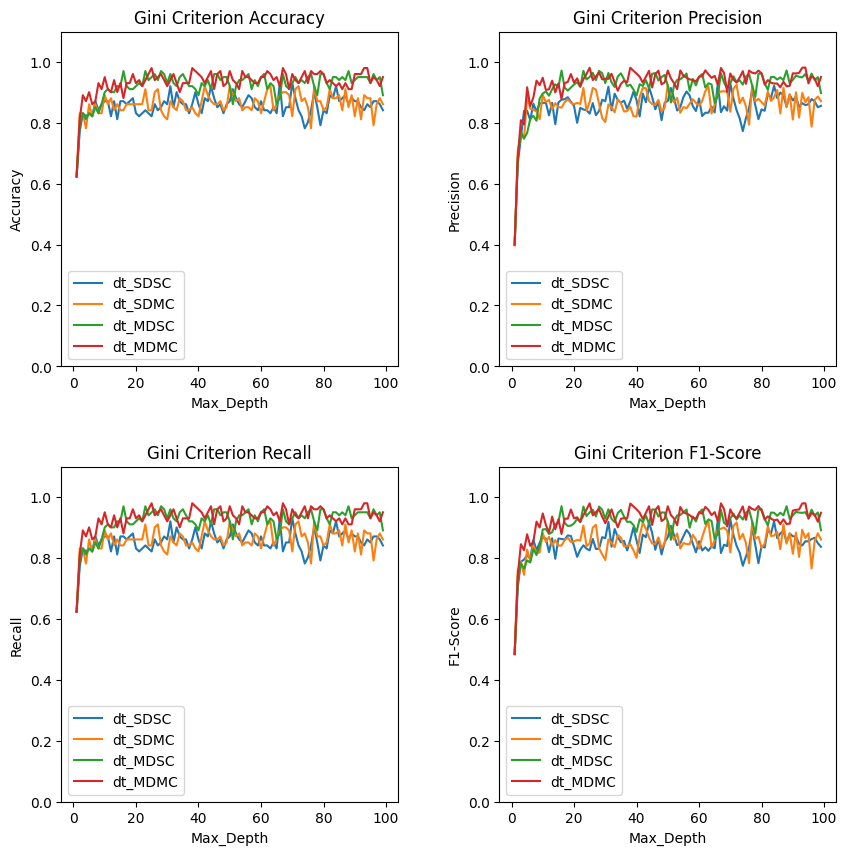

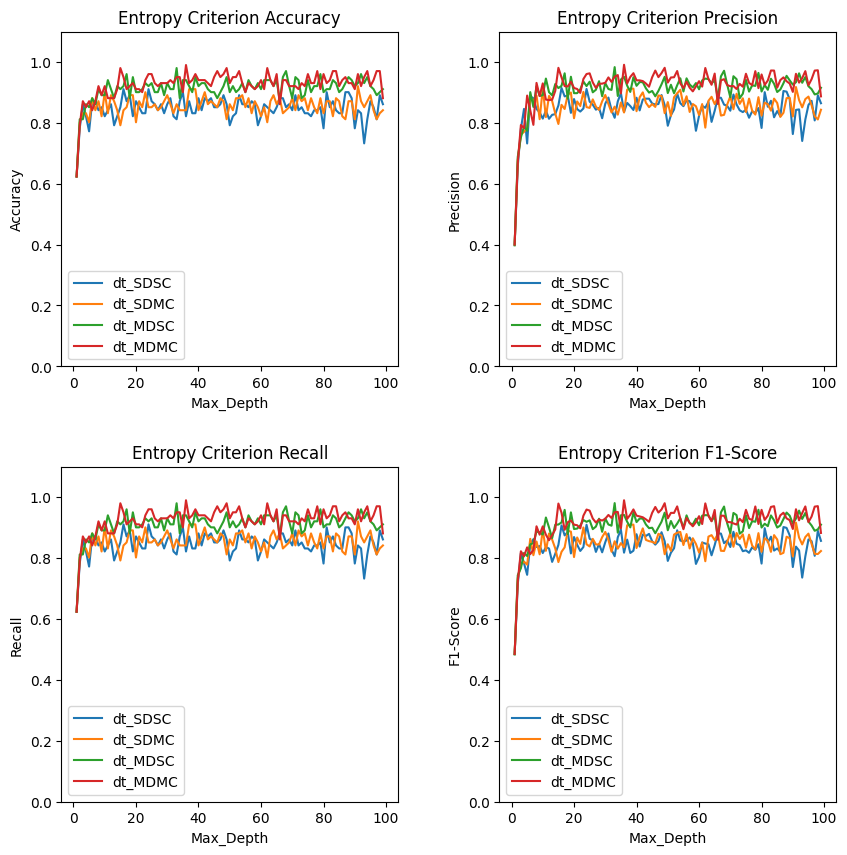

In [7]:
for setup in final_result:
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 2, 1) 
    metric = setup['criterion']
    plt.title((metric.title() + " Criterion Accuracy"))
    plt.ylabel('Accuracy')
    plt.xlabel('Max_Depth')
    plt.ylim(0.0, 1.1)
    for result in setup['results']:
       plt.plot(result['max_depth'], result['acc'], label=result['name'])
    plt.legend()
        
    plt.subplot(2, 2, 2) 
    plt.title((metric.title() + " Criterion Precision").title())
    plt.ylabel('Precision')
    plt.xlabel('Max_Depth')
    plt.ylim(0.0, 1.1)
    for result in setup['results']:
        plt.plot(result['max_depth'], result['prec'], label=result['name'])   
    plt.legend()
    
    plt.subplot(2, 2, 3) 
    plt.title((metric.title() + " Criterion Recall").title())
    plt.ylabel('Recall')
    plt.xlabel('Max_Depth')
    plt.ylim(0.0, 1.1)
    for result in setup['results']:
        plt.plot(result['max_depth'], result['recall'], label=result['name']) 
    plt.legend()
    
    plt.subplot(2, 2, 4) 
    plt.title((metric.title() + " Criterion F1-Score").title())
    plt.ylabel('F1-Score')
    plt.xlabel('Max_Depth')
    plt.ylim(0.0, 1.1)
    for result in setup['results']:
       plt.plot(result['max_depth'], result['f1'], label=result['name']) 
    plt.legend()
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

In [23]:
criterion = 'criterion'
metrics = []
for r in final_result:
    name = r[criterion].title()
    for result in r['results']:
        depth = 0
        acc = 0
        max_depth = 0
        max_prec = 0
        max_rec = 0
        max_f1 = 0
        variant = result['name']
        for i in range(len(result['acc'])):
            if result['acc'][i] > acc and result['depth'][i] == result['max_depth'][i]:
            # if result['y'][i] > acc:
                depth = result['depth'][i]
                acc =  result['acc'][i]
                max_depth = result['max_depth'][i]
                max_prec = result['prec'][i]
                max_rec = result['recall'][i]
                max_f1 = result['f1'][i]
        metrics.append({'criterion': name, 'name' : variant, 'acc':acc, 'prec': max_prec, 'rec':max_rec, 'f1': max_f1, 'max_depth' : max_depth, 'depth': depth})
        
        
splitter = '_'
for r in final_result:
    name = r[criterion].title()
    for result in r['results']:
        variant = result['name']
        no_prune_limit = 0
        for i in range(len(result['acc'])):
            if result['depth'][i] < result['max_depth'][i]:
                no_prune_limit = i
                break
        print(f'{variant.split(splitter)[1]} & {name} &  {no_prune_limit} \\\\')
        print("\\hline")
        
 

SDSC & Gini &  16 \\
\hline
SDMC & Gini &  14 \\
\hline
MDSC & Gini &  42 \\
\hline
MDMC & Gini &  32 \\
\hline
SDSC & Entropy &  16 \\
\hline
SDMC & Entropy &  14 \\
\hline
MDSC & Entropy &  26 \\
\hline
MDMC & Entropy &  24 \\
\hline


In [20]:
for end in metrics:
    print(end['name'].split('_')[1] + " & " + str(end['criterion']).title() + " & " + str(end['depth']) + " & " + str(round(end['acc'], 2)) + " & " + str(
        round(end['prec'], 2)) + " & " + str(round(end['rec'], 2)) + " & " + str(round(end['f1'], 2)) + "\\\\")
    print("\\hline")

SDSC & Gini & 7 & 0.87 & 0.86 & 0.87 & 0.86\\
\hline
SDMC & Gini & 10 & 0.89 & 0.89 & 0.89 & 0.88\\
\hline
MDSC & Gini & 16 & 0.97 & 0.97 & 0.97 & 0.97\\
\hline
MDMC & Gini & 25 & 0.98 & 0.98 & 0.98 & 0.98\\
\hline
SDSC & Entropy & 16 & 0.91 & 0.91 & 0.91 & 0.91\\
\hline
SDMC & Entropy & 10 & 0.9 & 0.91 & 0.9 & 0.89\\
\hline
MDSC & Entropy & 17 & 0.96 & 0.96 & 0.96 & 0.96\\
\hline
MDMC & Entropy & 15 & 0.98 & 0.98 & 0.98 & 0.98\\
\hline


In [9]:
'''
Gini | dt_SDSC | max_dept: 14 | acc: 0.8811881188118812, depth: 14
Gini | dt_SDMC | max_dept: 13 | acc: 0.900990099009901, depth: 13
Gini | dt_MDSC | max_dept: 19 | acc: 0.9504950495049505, depth: 19
Gini | dt_MDMC | max_dept: 21 | acc: 0.9702970297029703, depth: 21
Entropy | dt_SDSC | max_dept: 13 | acc: 0.9207920792079208, depth: 13
Entropy | dt_SDMC | max_dept: 13 | acc: 0.8712871287128713, depth: 13
Entropy | dt_MDSC | max_dept: 28 | acc: 0.9207920792079208, depth: 28
Entropy | dt_MDMC | max_dept: 23 | acc: 0.9603960396039604, depth: 23
Gini | dt_SDSC| prune limit: 16
Gini | dt_SDMC| prune limit: 18
Gini | dt_MDSC| prune limit: 38
Gini | dt_MDMC| prune limit: 37
Entropy | dt_SDSC| prune limit: 14
Entropy | dt_SDMC| prune limit: 14
Entropy | dt_MDSC| prune limit: 26
Entropy | dt_MDMC| prune limit: 23

'''

'\nGini | dt_SDSC | max_dept: 14 | acc: 0.8811881188118812, depth: 14\nGini | dt_SDMC | max_dept: 13 | acc: 0.900990099009901, depth: 13\nGini | dt_MDSC | max_dept: 19 | acc: 0.9504950495049505, depth: 19\nGini | dt_MDMC | max_dept: 21 | acc: 0.9702970297029703, depth: 21\nEntropy | dt_SDSC | max_dept: 13 | acc: 0.9207920792079208, depth: 13\nEntropy | dt_SDMC | max_dept: 13 | acc: 0.8712871287128713, depth: 13\nEntropy | dt_MDSC | max_dept: 28 | acc: 0.9207920792079208, depth: 28\nEntropy | dt_MDMC | max_dept: 23 | acc: 0.9603960396039604, depth: 23\nGini | dt_SDSC| prune limit: 16\nGini | dt_SDMC| prune limit: 18\nGini | dt_MDSC| prune limit: 38\nGini | dt_MDMC| prune limit: 37\nEntropy | dt_SDSC| prune limit: 14\nEntropy | dt_SDMC| prune limit: 14\nEntropy | dt_MDSC| prune limit: 26\nEntropy | dt_MDMC| prune limit: 23\n\n'